In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

%cd ../..

!hostname

/p/fastdata/pli/Private/oberstrass1/datasets/vervet1818-3d
jrlogin09.jureca


In [2]:
# Load quantity of interest and the cortex segmentation volume

laplace_path = "data/aa/volume/brain_visa/heat_6_fixed.nii.gz"
cortex_path = "data/aa/volume/cortex/cortex_6.h5"

###

import nibabel as nib
import numpy as np
import h5py as h5

laplace_nifti = nib.load(laplace_path)
laplace_spacing = tuple(np.diag(laplace_nifti.affine)[:3])
laplace_volume = np.array(laplace_nifti.dataobj)[:]

with h5.File(cortex_path, 'r') as f:
    cortex_volume = f['volume'][:][::-1, :, :]
    cortex_spacing = tuple(f['volume'].attrs['spacing'])

print("Shape:", laplace_volume.shape)
print("Spacing:", laplace_spacing)

Shape: (448, 243, 485)
Spacing: (0.084381103515625, 0.05999755859375, 0.084381103515625)


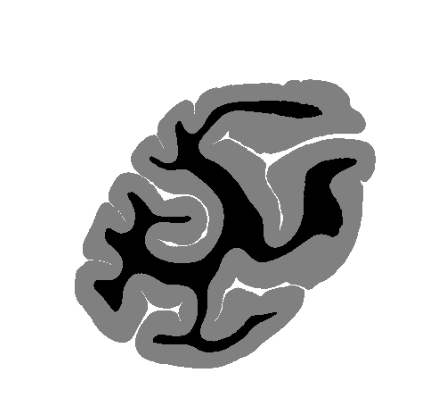

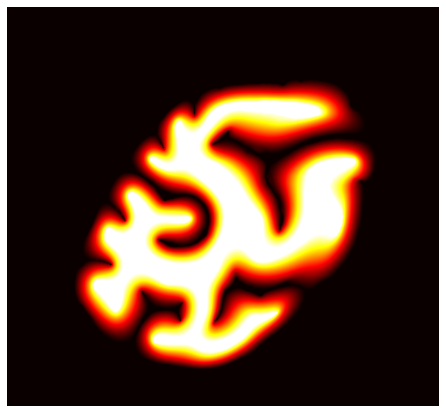

In [3]:
import pli.image as im

im.show(cortex_volume[:, 150, :])
im.show(laplace_volume[:, 150, :], cmap='hot')

Cutting direction: $y$

Laplace field $f(x, y, z)$

Gradient of Laplace field $\nabla f$

Curvature as divergence (Goldman 2005, Equation 3.8)

$k = -\nabla \cdot \left(\frac{\nabla F}{|\nabla F|}\right)$

In [4]:
# Cortex class
gm_class = 2

# Sigmas of Gaussian kernel per axis
smooth_sigmas = (1.0, 1.4, 1.0)

# Multiply for numerical stability
factor = 100.

# Minimum in-plane length for stability
eps = 0.1

###

from scipy.ndimage import gaussian_filter

# Smooth before application of gradient to mitigate edge effects
laplace_volume_smoothed = factor * laplace_volume.astype(np.float64)
laplace_volume_smoothed = gaussian_filter(laplace_volume_smoothed, smooth_sigmas)

# Divide by spacing for isotropic gradient calculation
dx = np.gradient(laplace_volume_smoothed, axis=0) / laplace_spacing[0]
dy = np.gradient(laplace_volume_smoothed, axis=1) / laplace_spacing[1]
dz = np.gradient(laplace_volume_smoothed, axis=2) / laplace_spacing[2]

# Normalize by length of the gradient
grad_len = np.maximum((dx ** 2 + dy ** 2 + dz ** 2) ** 0.5, 1e-6)

# Use divergence as measure of curvature
grad_norm_x = dx / grad_len
grad_norm_y = dy / grad_len
grad_norm_z = dz / grad_len

# Second order derivative
ddx =  np.gradient(grad_norm_x, axis=0)
ddy =  np.gradient(grad_norm_y, axis=1)
ddz =  np.gradient(grad_norm_z, axis=2)

# Divergence formula*
divergence = -(ddx + ddy + ddz)

# Set cutting angle at background and white-matter to 0
divergence[cortex_volume != gm_class] = 0.

divergence = divergence.astype(np.float32)

Divergence min: -2.3582497
Divergence max: 1.3115091


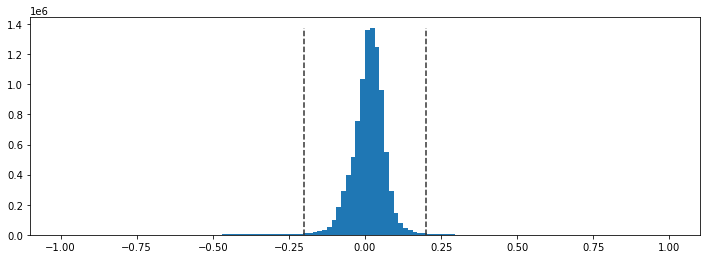

In [5]:
bins = 128

section_margin = 30

###


import matplotlib.pyplot as plt

divergence_margin = divergence[:, section_margin:-section_margin, :]
divergence_valid = divergence_margin[divergence_margin != 0.]

print("Divergence min:", np.min(divergence_valid))
print("Divergence max:", np.max(divergence_valid))

plt.figure(figsize=(12, 4))
hist = plt.hist(divergence_valid.flatten(), range=(-1, 1), bins=bins)
plt.vlines([-0.2, 0.2], 0, max(hist[0]), color='#333333', linestyles='--')
plt.show()

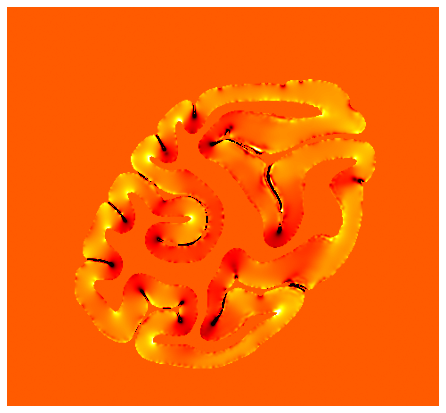

In [6]:
im.show(divergence[:, 150, :], scale=False, vmin=-0.25, vmax=0.25, cmap='hot')

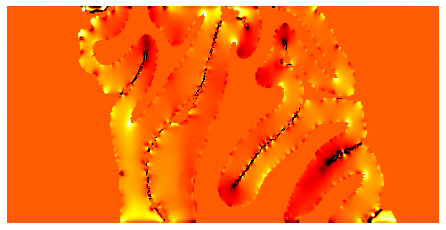

In [7]:
im.show(divergence[200, :, :], scale=False, vmin=-0.25, vmax=0.25, cmap='hot')

In [9]:
from pli.data.functions import write_nifti

write_nifti("data/aa/volume/brain_visa/divergence_6.nii", divergence, laplace_nifti.affine, gzip=True)